In [1]:
import jax.numpy as jnp
from jax import grad, vmap, jit, random, lax

import kagglehub
import matplotlib.pyplot as plt
import numpy as np

path = kagglehub.dataset_download("hojjatk/mnist-dataset")  # download mnist
key = random.PRNGKey(239)  # 239; 412
print(f'mnsit at: {path}')

mnsit at: /home/tibless/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [2]:
# load mnist

import os
import struct
import numpy as np

def read_idx(filename):
    """
    Read MNIST data from file using idx format.

    Return
    ------
    np.ndarray
    """
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

TRAIN = 6000
TEST  = 1000
train_images = read_idx(os.path.join(path, 'train-images.idx3-ubyte'))[:TRAIN]
train_labels = read_idx(os.path.join(path, 'train-labels.idx1-ubyte'))[:TRAIN]
test_images = read_idx(os.path.join(path, 't10k-images.idx3-ubyte'))[:TEST]
test_labels = read_idx(os.path.join(path, 't10k-labels.idx1-ubyte'))[:TEST]

shuffle_kernel = np.random.permutation(np.arange(TRAIN))
train_images = train_images[shuffle_kernel]
train_labels = train_labels[shuffle_kernel]

print("训练图像数据大小: ", train_images.shape)
print("训练标签数据大小: ", train_labels.shape)
print("测试图像数据大小: ", test_images.shape)
print("测试标签数据大小: ", test_labels.shape)

训练图像数据大小:  (6000, 28, 28)
训练标签数据大小:  (6000,)
测试图像数据大小:  (1000, 28, 28)
测试标签数据大小:  (1000,)


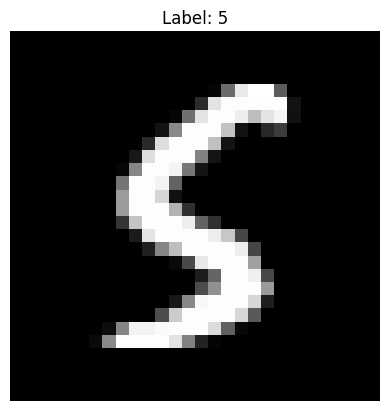

In [3]:
ix = 4
plt.imshow(train_images[ix], cmap='gray')
plt.title(f"Label: {train_labels[ix]}")
plt.axis('off')  # 不显示坐标轴
plt.show()

In [4]:
X_train = jnp.array(train_images.reshape(train_images.shape[0], 1, 28, 28)) / 255.
y_train = jnp.array(train_labels)
X_test = jnp.array(test_images.reshape(test_images.shape[0], 1, 28, 28)) / 255.
y_test = jnp.array(test_labels)

def one_hot(y: jnp.ndarray, num_class: int):
    res = jnp.zeros((y.shape[0], num_class))
    res = res.at[jnp.arange(y.shape[0]), y].set(1)
    return res

y_train_one_hot = one_hot(y_train, 10)
y_test_one_hot = one_hot(y_test, 10)

In [5]:
# Softmax & Loss, version without improvement: 
# softmax = lambda logits: jnp.exp(logits) / jnp.sum(jnp.exp(logits), axis=1, keepdims=True)
# cross_entropy_loss = lambda y, y_pred: jnp.sum(-y * jnp.log(y_pred), axis=1).mean()

def softmax(logits):
    logits_stable = logits - jnp.max(logits, axis=1, keepdims=True)
    exp_logits = jnp.exp(logits_stable)
    return exp_logits / jnp.sum(exp_logits, axis=1, keepdims=True)

def cross_entropy_loss(y, y_pred):
    epsilon = 1e-9
    y_pred_clipped = jnp.clip(y_pred, epsilon, 1. - epsilon)  # clip here is very important, or you will get Nan when you training. 
    loss = -jnp.sum(y * jnp.log(y_pred_clipped), axis=1)
    return loss.mean()

class RawVersion:
    @staticmethod
    def conv2d(x, w, b, padding=1):
        bs, icl, he, wi = x.shape  # input graph -> batch_size x channel x height x width
        ocl, icl, kh, kw = w.shape
        he = (he + 2*padding - kh + 1)
        wi = (wi + 2*padding - kw + 1)
        
        fgraph = jnp.zeros((bs, ocl, he, wi))  # feature graph
    
        # padding for x 
        pad_mat = (
            (0, 0),
            (0, 0),
            (padding, padding),
            (padding, padding)
        )
        
        x_padded = jnp.pad(x, pad_mat, mode='constant', constant_values=0)
    
        for k in range(ocl):
            for i in range(he):
                for j in range(wi):
                    fgraph.at[:, k, i, j].set(
                        jnp.sum(x_padded[:, :, i:i + kh, j:j + kw] * w[k], axis=(1, 2, 3)) + b[k]
                    )
    
        return fgraph

    @staticmethod
    def max_pooling2d(x, pool_size=(2, 2), stride=None):
        if stride is None:
            stride = pool_size
        
        batch_size, channels, height, width = x.shape
        pool_height, pool_width = pool_size
        stride_height, stride_width = stride
        
        output_height = (height - pool_height) // stride_height + 1
        output_width = (width - pool_width) // stride_width + 1
        
        output_array = jnp.zeros((batch_size, channels, output_height, output_width))
        
        for n in range(batch_size):
            for c in range(channels):
                for i in range(output_height):
                    for j in range(output_width):
                        window = x[n, c, 
                                        i * stride_height:i * stride_height + pool_height, 
                                        j * stride_width :j * stride_width  + pool_width]
                        output_array.at[n, c, i, j].set(
                            jnp.max(window)
                        )
        
        return output_array        


class JaxOptimaized:
    @staticmethod
    def conv2d(x, w, b, padding=1):
        dimension_numbers = ('NCHW', 'OIHW', 'NCHW')
        padding_mode = ((padding, padding), (padding, padding))  # 高度和宽度方向的padding
        
        out = lax.conv_general_dilated(
            lhs=x,
            rhs=w,
            window_strides=(1, 1),
            padding=padding_mode,
            lhs_dilation=(1, 1),
            rhs_dilation=(1, 1),
            dimension_numbers=dimension_numbers
        )
        
        return out + b[None, :, None, None]

    @staticmethod
    def max_pooling2d(x, pool_size=(2, 2), stride=None):
        if stride is None:
            stride = pool_size
        
        return lax.reduce_window(
            operand=x,
            init_value=-jnp.inf,
            computation=lax.max,
            window_dimensions=(1, 1, pool_size[0], pool_size[1]),
            window_strides=(1, 1, stride[0], stride[1]),
            padding='VALID'
        ) 

In [6]:
class LeNet:
    def __init__(self):
        self.config = {
            'conv2d:0' : {
                'input_channel': 1,
                'output_channel': 6,
                'kernel_size': 5,
                'padding': 2,
            },
            'max_pooling:0' : {
                'window_size': 2,
            },
            'conv2d:1' : {
                'input_channel': 6,
                'output_channel': 16,
                'kernel_size': 5,
                'padding': 0,
            },
            'relu:1': {},
            'max_pooling:1' : {
                'window_size': 2,
            },
            'flatten:0': {},
            'fc:0' : {
                'input_dim': 400,
                'output_dim': 120,
            },
            'relu:2': {},
            'fc:1' : {
                'input_dim': 120,
                'output_dim': 84,
            },
            'relu:3': {},
            'fc:2' : {
                'input_dim': 84,
                'output_dim': 10,
            },
            'relu:4': {}
        }

        self.params = {
            'conv2d:0': {
                'w': self._w_conv2d_init((
                    self.config['conv2d:0']['output_channel'],
                    self.config['conv2d:0']['input_channel'],
                    self.config['conv2d:0']['kernel_size'],
                    self.config['conv2d:0']['kernel_size'],
                )),  # (O, I, KH, KW)
                'b': jnp.zeros(self.config['conv2d:0']['output_channel']), # b: (O,)
            },
            'conv2d:1': {
                'w': self._w_conv2d_init((
                    self.config['conv2d:1']['output_channel'],
                    self.config['conv2d:1']['input_channel'],
                    self.config['conv2d:1']['kernel_size'],
                    self.config['conv2d:1']['kernel_size'],
                )),
                'b': jnp.zeros(self.config['conv2d:1']['output_channel'])
            },
            'fc:0': {
                'w': self._w_fc_init((
                    self.config['fc:0']['input_dim'],
                    self.config['fc:0']['output_dim'],
                )),
                'b': jnp.zeros(1),
            },
            'fc:1': {
                'w': self._w_fc_init((
                    self.config['fc:1']['input_dim'],
                    self.config['fc:1']['output_dim'],
                )),
                'b': jnp.zeros(1),
            },
            'fc:2': {
                'w': self._w_fc_init((
                    self.config['fc:2']['input_dim'],
                    self.config['fc:2']['output_dim'],
                )),
                'b': jnp.zeros(1),
            },
        }

        self.v_params = {k: {name: jnp.zeros_like(w) for name, w in v.items()} for k, v in self.params.items()}
        self.vv_params = {k: {name: jnp.zeros_like(w) for name, w in v.items()} for k, v in self.params.items()}

        self.step = 0

    def _adam_update(self, gs: dict, params, v_params, vv_params,
                    lr=0.01,
                    beta1=0.9,
                    beta2=0.999,
                    epsilon=1e-6):

        t = self.step + 1 # step of training, starting from 0, so add 1

        names = gs.keys()
        new_params, new_v_params, new_vv_params = [], [], []
        for g, w, v_w, vv_w in zip(gs.values(), params.values(), v_params.values(), vv_params.values()):
            new_w, new_v_w, new_vv_w = {}, {}, {}

            for ix in ['w', 'b']:
                new_v_w[ix] = beta1*v_w[ix] + (1 - beta1)*g[ix]
                new_vv_w[ix] = beta2*vv_w[ix] + (1 - beta2)*g[ix]*g[ix]
    
                v_w_hat = new_v_w[ix] / (1 - beta1**t)
                vv_w_hat = new_vv_w[ix] / (1 - beta2**t)
                step = - lr * v_w_hat / (jnp.sqrt(vv_w_hat) + epsilon)

                new_w[ix] = w[ix] + step

            new_params.append(new_w)
            new_v_params.append(new_v_w)
            new_vv_params.append(new_vv_w)

        return dict(zip(names, new_params)), dict(zip(names, new_v_params)), dict(zip(names, new_vv_params))
       

    def predict_proba(self, x: jnp.ndarray, params):
        res = x
        res = JaxOptimaized.conv2d(res, params['conv2d:0']['w'], params['conv2d:0']['b'], padding=self.config['conv2d:0']['padding'])
        res = jnp.maximum(0, res)
        res = JaxOptimaized.max_pooling2d(res, pool_size=(
            self.config['max_pooling:0']['window_size'],
            self.config['max_pooling:0']['window_size'],
        ))
        
        res = JaxOptimaized.conv2d(res, params['conv2d:1']['w'], params['conv2d:1']['b'], padding=self.config['conv2d:1']['padding'])
        res = jnp.maximum(0, res)
        res = JaxOptimaized.max_pooling2d(res, pool_size=(
            self.config['max_pooling:1']['window_size'],
            self.config['max_pooling:1']['window_size'],
        ))

        res = res.reshape(res.shape[0], -1)

        res = res @ params['fc:0']['w'] + params['fc:0']['b']
        res = jnp.maximum(0, res)
        
        res = res @ params['fc:1']['w'] + params['fc:1']['b']
        res = jnp.maximum(0, res)
        
        res = res @ params['fc:2']['w'] + params['fc:2']['b']
        res = jnp.maximum(0, res)

        res = softmax(res)
        return res
       
    def _w_fc_init(self, w_shape):
        w = random.normal(key, w_shape) * jnp.sqrt(2 / (w_shape[0]))  # kaiming: sqrt(2 / Input_dim)
        return w

    def _w_conv2d_init(self, w_shape):
        w = random.normal(key, w_shape) * jnp.sqrt(2 / (w_shape[0] * w_shape[1] * w_shape[2]))  # kaiming: sqrt(2 / I x KH x KH)
        return w
 
    def fit(self, x_train, y_train_proba, x_test, y_test_proba, 
            epoches=100, 
            lr=0.1,
            beta1=0.9,
            beta2=0.999,
            epsilon=1e-6): 
        
        def _acc(y_true_proba, y_pred_proba):
            y_true = jnp.argmax(y_true_proba, axis=1)
            y_pred = jnp.argmax(y_pred_proba, axis=1)
            return np.mean(y_true == y_pred)

        _loss = lambda params: cross_entropy_loss(y_train_proba, softmax(self.predict_proba(x_train, params))) 
        _loss = jit(_loss)  # accelerate loss function by JIT
        
        _tloss = lambda params: cross_entropy_loss(y_test_proba, softmax(self.predict_proba(x_test, params))) 
        
        acc, loss, tacc, tloss = [], [], [], []  # train acc, train loss, test acc, test loss
        
        for _ in range(epoches):
            loss.append(_loss(self.params))
            tloss.append(_tloss(self.params))

            d_params = grad(_loss, argnums=0)(self.params)

            # Adam
            self.params, self.v_params, self.vv_params = self._adam_update(d_params, self.params, self.v_params, self.vv_params, lr, beta1, beta2, epsilon)
            
            self.step += 1  # remember update step, all variants updated.
            
            acc.append(_acc(y_train_proba, self.predict_proba(x_train, self.params)))
            tacc.append(_acc(y_test_proba, self.predict_proba(x_test, self.params)))
            if self.step % 10 == 0:
                print(f'>> epoch: {self.step}, train acc: {acc[-1]}, test acc: {tacc[-1]}')

        return acc, loss, tacc, tloss       


In [7]:
epochs = 300
model = LeNet()
acc, loss, tacc, tloss = model.fit(
    x_train=X_train, 
    y_train_proba=y_train_one_hot,
    x_test=X_test,
    y_test_proba=y_test_one_hot,
    epoches=epochs,
    lr=0.01)

>> epoch: 10, train acc: 0.35883334279060364, test acc: 0.359000027179718
>> epoch: 20, train acc: 0.40299999713897705, test acc: 0.3920000195503235
>> epoch: 30, train acc: 0.4088333249092102, test acc: 0.3960000276565552
>> epoch: 40, train acc: 0.41316667199134827, test acc: 0.39900001883506775
>> epoch: 50, train acc: 0.41600000858306885, test acc: 0.39900001883506775
>> epoch: 60, train acc: 0.4166666567325592, test acc: 0.39900001883506775
>> epoch: 70, train acc: 0.4829999804496765, test acc: 0.4480000138282776
>> epoch: 80, train acc: 0.5886666774749756, test acc: 0.5590000152587891
>> epoch: 90, train acc: 0.6029999852180481, test acc: 0.578000009059906
>> epoch: 100, train acc: 0.6085000038146973, test acc: 0.5800000429153442
>> epoch: 110, train acc: 0.7020000219345093, test acc: 0.6600000262260437
>> epoch: 120, train acc: 0.7836666703224182, test acc: 0.7460000514984131
>> epoch: 130, train acc: 0.8034999966621399, test acc: 0.7600000500679016
>> epoch: 140, train acc: 0.8

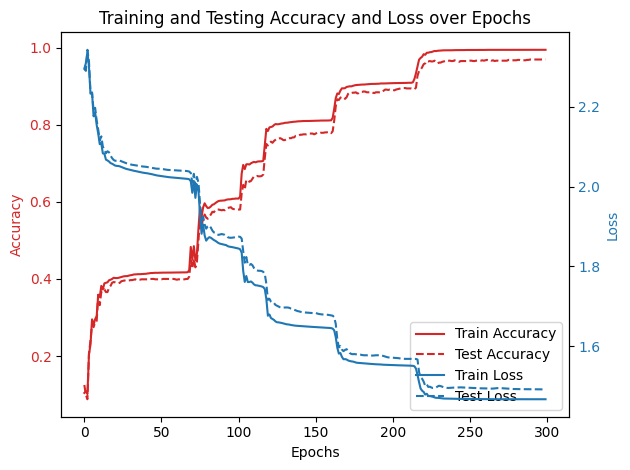

final train, test acc : 0.9941666722297668, 0.9690000414848328
final train, test loss: 1.4669420719146729, 1.4916566610336304


In [8]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(range(epochs), acc, color=color, label='Train Accuracy', linestyle='-')
ax1.plot(range(epochs), tacc, color=color, label='Test Accuracy', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  
ax2.plot(range(epochs), loss, color=color, label='Train Loss', linestyle='-')
ax2.plot(range(epochs), tloss, color=color, label='Test Loss', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='lower right')

plt.title('Training and Testing Accuracy and Loss over Epochs')
fig.tight_layout()
plt.show()

print(f'final train, test acc : {acc[-1]}, {tacc[-1]}')
print(f'final train, test loss: {loss[-1]}, {tloss[-1]}')